# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
#Install requirements
!pip install -r requirements.txt

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline


The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
patience = 10

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


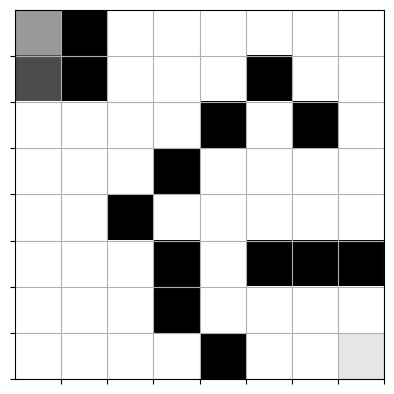

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell, max_steps=None):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    steps = 0
    if max_steps is None:
        max_steps = qmaze.maze.size * 4  # safety cutoff

    while steps < max_steps:
        s = np.asarray(envstate, dtype=np.float32)
        if s.ndim == 1:
            s = np.expand_dims(s, axis=0)

        q = model(s, training=False).numpy()[0]
        valid = qmaze.valid_actions()
        if valid:
            mask = np.full_like(q, -1e9, dtype=np.float32)
            mask[valid] = q[valid]
            action = int(np.argmax(mask))
        else:
            action = int(np.argmax(q))

        envstate, reward, status = qmaze.act(action)
        if status == 'win':  return True
        if status == 'lose': return False
        steps += 1

    return False  # timed out

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, maze_or_qmaze, max_steps=None):
    # Accept either raw numpy maze or TreasureMaze instance
    if isinstance(maze_or_qmaze, TreasureMaze):
        qmaze = maze_or_qmaze
    else:
        qmaze = TreasureMaze(maze_or_qmaze)

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            continue
        if not play_game(model, qmaze, cell, max_steps=max_steps):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        q_values = model(x, training=True)
        loss = loss_fn(y, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [11]:
def qtrain(model, maze, **opt):
    import datetime, random
    from tensorflow.keras.models import clone_model

    # Format time helper function
    def format_time_local(seconds):
        if seconds < 400:
            s = float(seconds)
            return "%.1f seconds" % (s,)
        elif seconds < 4000:
            m = seconds / 60.0
            return "%.2f minutes" % (m,)
        else:
            h = seconds / 3600.0
            return "%.2f hours" % (h,)

    # Global variables or default if missing
    global epsilon, epsilon_min, epsilon_decay
    try:
        epsilon
    except NameError:
        epsilon = opt.get('epsilon', 1.0)
    try:
        epsilon_min
    except NameError:
        epsilon_min = opt.get('epsilon_min', 0.05)
    try:
        epsilon_decay
    except NameError:
        epsilon_decay = opt.get('epsilon_decay', 0.995)

    # parameters
    n_epoch            = opt.get('n_epoch', 15000)
    max_memory         = opt.get('max_memory', 1000)
    data_size          = opt.get('data_size', 50)
    target_update_freq = opt.get('target_update_freq', 50)
    max_steps_ep       = opt.get('max_steps_ep', None)

    # Track training time
    start_time = datetime.datetime.now()

    # Initialize maze
    qmaze = TreasureMaze(maze)

    # Clones model for target network
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())

    # Replay memory to store experiences
    experience = GameExperience(model, target_model, max_memory=max_memory)

    # Track performance
    win_history = []
    hsize = max(1, qmaze.maze.size // 2)
    win_rate = 0.0

    episodes_seen = 0
    last_loss = 0.0

    # mex episode step if none given
    if max_steps_ep is None:
        max_steps_ep = qmaze.maze.size * 4

    # Training main function
    for epoch in range(n_epoch):
        # pick a random start cell
        start_cell = random.choice(qmaze.free_cells)
        while not qmaze.valid_actions(start_cell):
            start_cell = random.choice(qmaze.free_cells)

        # Environment reset for start
        qmaze.reset(start_cell)
        envstate = qmaze.observe()
        game_over = False
        steps = 0

        # episode loop
        while not game_over and steps < max_steps_ep:
            state = np.asarray(envstate, dtype=np.float32)
            if state.ndim == 1:
                state = np.expand_dims(state, axis=0)

            # Exploration, choose a random action
            if np.random.rand() <= epsilon:
                action = np.random.choice([LEFT, UP, RIGHT, DOWN])
                valid = qmaze.valid_actions()
                if valid:
                    action = np.random.choice(valid)
            else:
                # Exploitation, use model to predict best action
                q_vals = model(state, training=False).numpy()[0]
                valid = qmaze.valid_actions()
                if valid:
                    # mask invalid actions so agent doesn't select invalid move
                    mask = np.full_like(q_vals, -1e9, dtype=np.float32)
                    mask[valid] = q_vals[valid]
                    action = int(np.argmax(mask))
                else:
                    action = int(np.argmax(q_vals))

            # step
            envstate_next, reward, status = qmaze.act(action)
            done = (status != 'not_over')

            # store experience in memory
            experience.remember([state.reshape(1, -1).astype(np.float32),
                                 action,
                                 reward,
                                 envstate_next.astype(np.float32),
                                 done])

            # train from replay if enough samples
            x, y = experience.get_data(batch_size=data_size)
            if x.shape[0] > 0:
                last_loss = float(model.train_on_batch(x, y))

            # MOve to next state and continue
            envstate = envstate_next
            game_over = done
            steps += 1

        # End of episode and bookkeeping
        episodes_seen += 1
        win_history.append(1 if status == 'win' else 0)

        # rolling win rate
        window = win_history[-hsize:]
        win_rate = sum(window) / float(len(window)) if window else 0.0

        # Epsilon decay rate change after becoming better
        epsilon = max(epsilon * epsilon_decay, epsilon_min) if win_rate <= 0.9 else epsilon_min

        # Network sync for stability
        if episodes_seen % target_update_freq == 0:
            target_model.set_weights(model.get_weights())

        # log
        dt = datetime.datetime.now() - start_time
        t = format_time_local(dt.total_seconds())
        print("Epoch: {:05d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Wins: {:d} | Win rate: {:.3f} | time: {}".format(
            epoch, n_epoch - 1, last_loss, episodes_seen, sum(win_history), win_rate, t))

        # early stop after training complete
        if win_rate >= 0.999 and completion_check(model, maze):
            print(f"Reached ~100% win rate at epoch {epoch}")
            break

    total_time = format_time_local((datetime.datetime.now() - start_time).total_seconds())
    print("Training complete in:", total_time)


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

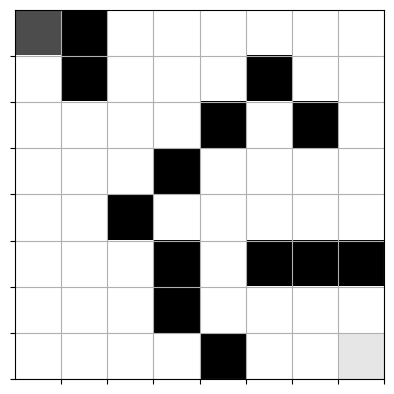

In [12]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [13]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32, target_update_freq=50)

C:\Users\chris\Downloads\pirate-intelligent-agent (2)\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 00000/999 | Loss: 0.0025 | Episodes: 1 | Wins: 0 | Win rate: 0.000 | time: 1.2 seconds
Epoch: 00001/999 | Loss: 0.0023 | Episodes: 2 | Wins: 0 | Win rate: 0.000 | time: 1.9 seconds
Epoch: 00002/999 | Loss: 0.0022 | Episodes: 3 | Wins: 0 | Win rate: 0.000 | time: 2.7 seconds
Epoch: 00003/999 | Loss: 0.0022 | Episodes: 4 | Wins: 0 | Win rate: 0.000 | time: 3.3 seconds
Epoch: 00004/999 | Loss: 0.0022 | Episodes: 5 | Wins: 0 | Win rate: 0.000 | time: 4.0 seconds
Epoch: 00005/999 | Loss: 0.0021 | Episodes: 6 | Wins: 0 | Win rate: 0.000 | time: 4.6 seconds
Epoch: 00006/999 | Loss: 0.0021 | Episodes: 7 | Wins: 1 | Win rate: 0.143 | time: 5.0 seconds
Epoch: 00007/999 | Loss: 0.0021 | Episodes: 8 | Wins: 1 | Win rate: 0.125 | time: 5.7 seconds
Epoch: 00008/999 | Loss: 0.0021 | Episodes: 9 | Wins: 2 | Win rate: 0.222 | time: 5.7 seconds
Epoch: 00009/999 | Loss: 0.0022 | Episodes: 10 | Wins: 2 | Win rate: 0.200 | time: 6.4 seconds
Epoch: 00010/999 | Loss: 0.0022 | Episodes: 11 | Wins: 2 | 

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

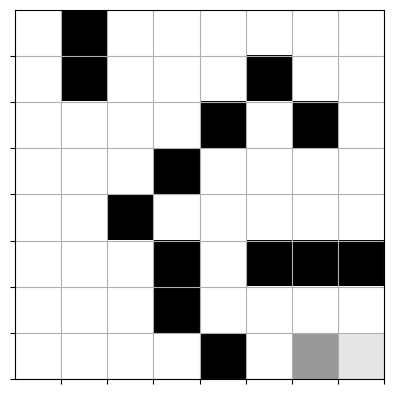

In [14]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

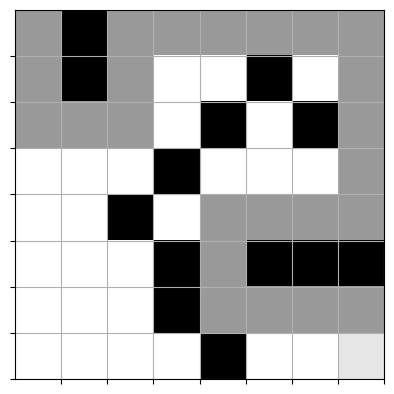

In [15]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***.
Download a copy of your .html file and submit it to Brightspace.

Won? True


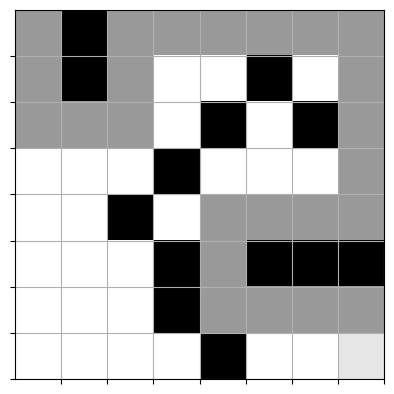

In [16]:
# fresh maze for a single run
qv = TreasureMaze(maze)

pirate_start = (0, 0)  # or any free cell
won = play_game(model, qv, pirate_start, max_steps=qv.maze.size*4)
print("Won?", won)

show(qv)  # <-- now shows the final pirate cell and visited path

Won? True


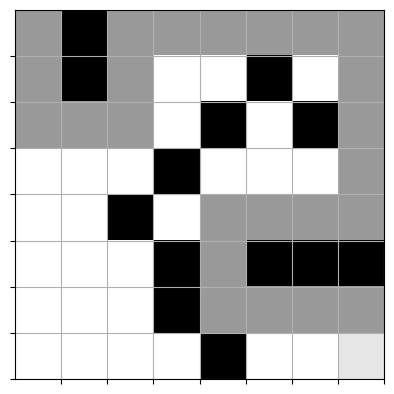

In [17]:
# Double checking
qv = TreasureMaze(maze)

pirate_start = (0, 0)
won = play_game(model, qv, pirate_start, max_steps=qv.maze.size*4)
print("Won?", won)

show(qv)
